## Big Data Project

Andrea Quevedo 

In [1]:
#Setup
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#Loading Data and Feature Engineering
from pyspark.sql.types import *
import json
from pyspark.sql import Row
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType
from datetime import datetime

#Exploratory Data Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Machine Learning Models
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [2]:
spark

### Importing Reddit LZO Data Files

In [3]:
#Reading LZO as Hadoop file
json_lzo = sc.newAPIHadoopFile("s3://bigdatateaching/reddit/lzo/RC_*.lzo",
                               "com.hadoop.mapreduce.LzoTextInputFormat",
                               "org.apache.hadoop.io.LongWritable",
                               "org.apache.hadoop.io.Text")

In [4]:
#Getting the schema from the sample data
data= spark.read.json("s3://bigdatateaching/reddit/sample-data/1m-line-sample.json")
schema=data.schema.json()

new_schema = StructType.fromJson(json.loads(schema))
new_schema

StructType(List(StructField(archived,BooleanType,true),StructField(author,StringType,true),StructField(author_cakeday,BooleanType,true),StructField(author_created_utc,LongType,true),StructField(author_flair_background_color,StringType,true),StructField(author_flair_css_class,StringType,true),StructField(author_flair_richtext,ArrayType(StructType(List(StructField(a,StringType,true),StructField(e,StringType,true),StructField(t,StringType,true),StructField(u,StringType,true))),true),true),StructField(author_flair_template_id,StringType,true),StructField(author_flair_text,StringType,true),StructField(author_flair_text_color,StringType,true),StructField(author_flair_type,StringType,true),StructField(author_fullname,StringType,true),StructField(author_patreon_flair,BooleanType,true),StructField(body,StringType,true),StructField(can_gild,BooleanType,true),StructField(can_mod_post,BooleanType,true),StructField(collapsed,BooleanType,true),StructField(collapsed_reason,StringType,true),StructFiel

In [5]:
#Converting the LZO file as a dataframe
data = json_lzo.map(lambda x:Row(x[1]))\
    .toDF(['raw'])\
    .select(F.from_json('raw',new_schema).alias('json')).select('json.*')

### Initial Data Inspection 

In [6]:
#Checking features and feature types
data.printSchema()

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_created_utc: long (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- a: string (nullable = true)
 |    |    |-- e: string (nullable = true)
 |    |    |-- t: string (nullable = true)
 |    |    |-- u: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-

In [7]:
#Checking for missing values 
data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in data.columns]).show()

+---------+------+--------------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+--------------------+----+--------+------------+---------+----------------+----------------+-----------+-------------+------+------+--------+---+------------+-------+---------+---------+---------+--------------+------------+-----+------------+--------+---------+------------+-----------------------+--------------+
| archived|author|author_cakeday|author_created_utc|author_flair_background_color|author_flair_css_class|author_flair_richtext|author_flair_template_id|author_flair_text|author_flair_text_color|author_flair_type|author_fullname|author_patreon_flair|body|can_gild|can_mod_post|collapsed|collapsed_reason|controversiality|created_utc|distinguished|edited|gilded|gildings| id|is_submitter|link_id|no_follow|parent_id|permalink|removal_reason|retrieved_on|score

Printing missing values in a more interpretable way


| Variable                      | Missing Obs. |
|-------------------------------|--------------|
| archived                      | 129352624    |
| author                        | 0            |
| author_cakeday                | 474710486    |
| author_created_utc            | 42738322     |
| author_flair_background_color | 323529952    |
| author_flair_css_class        | 371349643    |
| author_flair_richtext         | 42737313     |
| author_flair_template_id      | 414663455    |
| author_flair_text             | 368524948    |
| author_flair_text_color       | 323529952    |
| author_flair_type             | 42737313     |
| author_fullname               | 42737313     |
| author_patreon_flair          | 49013039     |
| body                          | 0            |
| can_gild                      | 0            |
| can_mod_post                  | 0            |
| collapsed                     | 0            |
| collapsed_reason              | 469533816    |
| controversiality              | 0            |
| created_utc                   | 0            |
| distinguished                 | 468689710    |
| edited                        | 0            |
| gilded                        | 0            |
| gildings                      | 0            |
| id                            | 0            |
| is_submitter                  | 0            |
| link_id                       | 0            |
| no_follow                     | 0            |
| parent_id                     | 0            |
| permalink                     | 0            |
| removal_reason                | 476258225    |
| retrieved_on                  | 0            |
| score                         | 0            |
| send_replies                  | 0            |
| stickied                      | 0            |
| subreddit                     | 0            |
| subreddit_id                  | 0            |
| subreddit_name_prefixed       | 0            |
| subreddit_type                | 0            |

### Data Cleaning

In [8]:
#List of variables to drop. Variables are being dropped either because they contain a lot of missing values or because 
#they will not be useful for the analysis later on
drop_cols= ['author_cakeday','author_flair_background_color','author_flair_css_class', 'author_flair_richtext','author_flair_template_id', 
            'author_flair_text', 'author_flair_text_color', 'author_flair_type','author_fullname','author_patreon_flair',
            'collapsed_reason', 'removal_reason', 'can_mod_post', 'gildings', 'is_submitter', 'permalink', 'retrieved_on', 
            'subreddit_name_prefixed', 'subreddit_id', 'parent_id', 'link_id','archived', 'id', 'distinguished', 'edited']

In [9]:
#Dropping variables from dataframe
for c in drop_cols:
    data = data.drop(c)

In [10]:
#Dropping missing values. The only variable left that includes missing values is author_created_utc, so will
#drop NAs based on that column only
data= data.dropna(subset='author_created_utc')

### Feature Engineering

In [11]:
#Creating a feature for post length (in characters)
data= data.withColumn('post_char_len', F.length('body'))

In [12]:
#Converting author_created_utc and created_utc to timestamp data type
data = data.withColumn("created_utc", data.created_utc.cast(TimestampType()))
data = data.withColumn("author_created_utc", data.author_created_utc.cast(TimestampType()))

In [13]:
#Creating new features that show day of week and time each post was created.
find_weekday =  F.udf(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%w'))

data = data.withColumn('shortdate',F.col('created_utc').substr(1, 10))\
    .withColumn('weekday', find_weekday(F.col('shortdate')))\
    .drop('shortdate')

data = data.withColumn('hour_posted',F.hour(F.col('created_utc')))

In [14]:
#Creating a new feature for time difference between post and account creation date
data = data.withColumn("account_active_time", F.datediff("created_utc","author_created_utc"))

In [15]:
#Casting additional variables 
data = data.withColumn('send_replies', data.send_replies.cast('integer'))
data = data.withColumn('no_follow', data.no_follow.cast('integer'))
data = data.withColumn('collapsed', data.collapsed.cast('integer'))
data = data.withColumn('can_gild', data.can_gild.cast('integer'))
data = data.withColumn('stickied', data.stickied.cast('integer'))

#Dropping body since there is no NLP component to this assignment and dropping utc variables since we wont need them anymore
data = data.drop('body')
data = data.drop('author_created_utc')
data = data.drop('created_utc')

### Exploratory Data Analysis (EDA)

In [16]:
#Looking at the resulting schema
data.printSchema()

root
 |-- author: string (nullable = true)
 |-- can_gild: integer (nullable = true)
 |-- collapsed: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- no_follow: integer (nullable = true)
 |-- score: long (nullable = true)
 |-- send_replies: integer (nullable = true)
 |-- stickied: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_type: string (nullable = true)
 |-- post_char_len: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- hour_posted: integer (nullable = true)
 |-- account_active_time: integer (nullable = true)



In [17]:
#Caching a dataframe is a mechanism to speed up applications that access the same dataframe multiple times
#Doing so in order to speed out the production of tables below as well as the modeling tasks that follow.
data.cache()

DataFrame[author: string, can_gild: int, collapsed: int, controversiality: bigint, gilded: bigint, no_follow: int, score: bigint, send_replies: int, stickied: int, subreddit: string, subreddit_type: string, post_char_len: int, weekday: string, hour_posted: int, account_active_time: int]

In [18]:
#Number of columns
len(data.columns)

15

In [19]:
#Number of rows
data.count()

433521422

In [20]:
#Checking for missing data. 
#After cleaning, we have zero missing values in each of our columns
data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in data.columns]).show()

+------+--------+---------+----------------+------+---------+-----+------------+--------+---------+--------------+-------------+-------+-----------+-------------------+
|author|can_gild|collapsed|controversiality|gilded|no_follow|score|send_replies|stickied|subreddit|subreddit_type|post_char_len|weekday|hour_posted|account_active_time|
+------+--------+---------+----------------+------+---------+-----+------------+--------+---------+--------------+-------------+-------+-----------+-------------------+
|     0|       0|        0|               0|     0|        0|    0|           0|       0|        0|             0|            0|      0|          0|                  0|
+------+--------+---------+----------------+------+---------+-----+------------+--------+---------+--------------+-------------+-------+-----------+-------------------+



In [21]:
#Taking a look at the first five rows of the dataframe 
pd.DataFrame(data.take(5), columns=data.columns)

,author,can_gild,collapsed,controversiality,gilded,no_follow,score,send_replies,stickied,subreddit,subreddit_type,post_char_len,weekday,hour_posted,account_active_time
0,TistedLogic,1,0,0,0,1,2,1,0,Unexpected,public,55,1,0,2613
1,misssaladfingers,1,0,0,0,1,1,1,0,insomnia,public,129,1,0,18
2,Increase_Vitality,1,0,0,0,0,37,1,0,pics,public,833,1,0,817
3,volkanize,1,0,0,0,1,1,1,0,NoStupidQuestions,public,200,1,0,76
4,FeveredArtist,1,0,0,0,1,1,1,0,FortNiteMobile,public,153,1,0,560


#### Continuous Variables

**Tables**

In [22]:
#Selecting and describing continuous variables
num_cols = ['gilded', 'score', 'post_char_len','account_active_time']
data.select(num_cols).describe().show()

+-------+--------------------+------------------+------------------+-------------------+
|summary|              gilded|             score|     post_char_len|account_active_time|
+-------+--------------------+------------------+------------------+-------------------+
|  count|           433521422|         433521422|         433521422|          433521422|
|   mean|2.463361545257157E-4| 9.769788386604803| 169.8443738657971| 1024.9049108719707|
| stddev|0.018623834331382316|141.53443510549874|315.95104164773454|   902.731723743485|
|    min|                   0|            -22280|                 0|                  0|
|    max|                  66|             90192|             33374|               4985|
+-------+--------------------+------------------+------------------+-------------------+



In [23]:
#Number of comments with a negative score
data.filter(data['score'] < 0).count()

16295699

In [24]:
#Number of comments with a positive score
data.filter(data['score'] > 0).count()

402731807

**Graphs**

Text(0.5, 1.0, 'Histogram of gilded count')

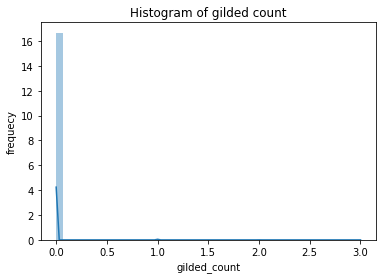

In [25]:
#Taking a 1,000,000 random sample of the dataset and graphing the distribution of the 'gilded' and 'score' variables
#1,000,000 represents a fraction of 0.0023 of 433,521,422
gilded_df = data.select(['gilded']).sample(False, 0.0023, 12345).toPandas()
sns.distplot(gilded_df)
plt.xlabel('gilded_count')
plt.ylabel('frequecy')
plt.title('Histogram of gilded count')

Text(0.5, 1.0, 'Histogram of post scores')

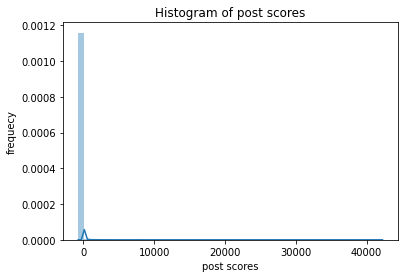

In [26]:
score_df = data.select(['score']).sample(False, 0.0023, 12345).toPandas()
sns.distplot(score_df)
plt.xlabel('post scores')
plt.ylabel('frequecy')
plt.title('Histogram of post scores')

Text(0.5, 1.0, 'Histogram of post length')

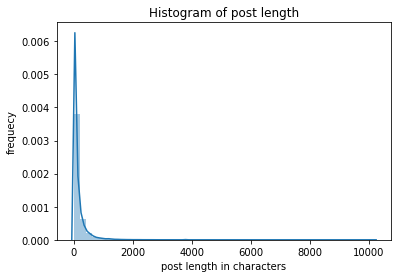

In [27]:
length_df = data.select(['post_char_len']).sample(False, 0.0023, 12345).toPandas()
sns.distplot(length_df)
plt.xlabel('post length in characters')
plt.ylabel('frequecy')
plt.title('Histogram of post length')

Text(0.5, 1.0, 'Histogram of account active time')

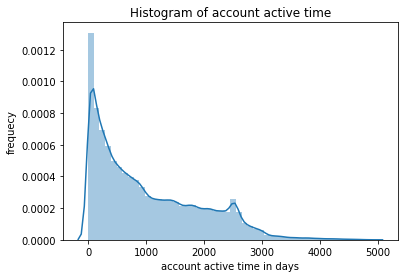

In [28]:
aat_df = data.select(['account_active_time']).sample(False, 0.0023, 12345).toPandas()
sns.distplot(aat_df)
plt.xlabel('account active time in days')
plt.ylabel('frequecy')
plt.title('Histogram of account active time')

#### Discrete Variables

**Tables**

Count for each binary variable

In [29]:
data.groupby('controversiality').count().show()

+----------------+---------+
|controversiality|    count|
+----------------+---------+
|               0|424029603|
|               1|  9491819|
+----------------+---------+



In [30]:
data.groupby('can_gild').count().show()

+--------+---------+
|can_gild|    count|
+--------+---------+
|       1|432275823|
|       0|  1245599|
+--------+---------+



In [31]:
data.groupby('collapsed').count().show()

+---------+---------+
|collapsed|    count|
+---------+---------+
|        1|  6181499|
|        0|427339923|
+---------+---------+



In [32]:
data.groupby('no_follow').count().show()

+---------+---------+
|no_follow|    count|
+---------+---------+
|        1|329713769|
|        0|103807653|
+---------+---------+



In [33]:
data.groupby('send_replies').count().show()

+------------+---------+
|send_replies|    count|
+------------+---------+
|           1|427254946|
|           0|  6266476|
+------------+---------+



In [34]:
data.groupby('stickied').count().show()

+--------+---------+
|stickied|    count|
+--------+---------+
|       1|  2636044|
|       0|430885378|
+--------+---------+



Count for categorical variables with multiple categories. Displaying the count in descending order. 

In [35]:
data.groupby('weekday').count().sort(F.desc('count')).show()

+-------+--------+
|weekday|   count|
+-------+--------+
|      3|66190082|
|      4|65400455|
|      2|65332277|
|      1|64068419|
|      5|60779579|
|      0|57469392|
|      6|54281218|
+-------+--------+



In [36]:
data.groupby('hour_posted').count().sort(F.desc('count')).show()

+-----------+--------+
|hour_posted|   count|
+-----------+--------+
|         19|24061245|
|         18|24016425|
|         20|23873514|
|         17|23823914|
|         21|23407316|
|         16|23134295|
|         22|22231379|
|         15|21627140|
|         23|21203813|
|          0|20775667|
|          1|20726325|
|          2|20640371|
|          3|19560484|
|         14|19217364|
|          4|17421732|
|         13|16309633|
|          5|15034442|
|         12|13207787|
|          6|12731934|
|          7|11038808|
+-----------+--------+
only showing top 20 rows



In [37]:
data.groupby('subreddit').count().sort(F.desc('count')).show()

+-----------------+--------+
|        subreddit|   count|
+-----------------+--------+
|        AskReddit|22743092|
|         politics| 7849124|
|              nfl| 5223387|
|            funny| 3930650|
|              nba| 3821067|
|       The_Donald| 3570514|
|        worldnews| 3066889|
|              CFB| 3051261|
|           gaming| 2980313|
|       FortNiteBR| 2920136|
|        dankmemes| 2806927|
|         AskOuija| 2732205|
|             pics| 2554881|
|            memes| 2379106|
|             news| 2329501|
|           soccer| 2311971|
|  leagueoflegends| 2288515|
|   Showerthoughts| 2154969|
|reddeadredemption| 2080428|
| unpopularopinion| 2064818|
+-----------------+--------+
only showing top 20 rows



In [38]:
data.groupby('subreddit_type').count().sort(F.desc('count')).show()

+---------------+---------+
| subreddit_type|    count|
+---------------+---------+
|         public|429460085|
|     restricted|  3440192|
|           user|   621143|
|gold_restricted|        2|
+---------------+---------+



In [39]:
data.groupby('author').count().sort(F.desc('count')).show()

+--------------------+-------+
|              author|  count|
+--------------------+-------+
|       AutoModerator|5222586|
|    MemeInvestor_bot| 307896|
|         transcribot| 269443|
|KeepingDankMemesDank| 222801|
|transcribersofreddit| 198197|
| NFCAAOfficialRefBot| 136902|
|      MTGCardFetcher| 130178|
|          vokoxazara| 126528|
|       imguralbumbot| 114199|
|          mediapedia|  99348|
|CommonMisspellingBot|  92196|
|      TotesMessenger|  87903|
|         Marketron-I|  87577|
|        SnapshillBot|  72432|
|          GVHFYTRTGH|  70857|
|        sneakpeekbot|  70822|
|           ManyYoung|  67701|
|         WikiTextBot|  61143|
|         request_bot|  60551|
|        timezone_bot|  59992|
+--------------------+-------+
only showing top 20 rows



Counting number of unique authors, subreddit types, and account active times 

In [41]:
data.select(F.countDistinct('author')).show()

+----------------------+
|count(DISTINCT author)|
+----------------------+
|              10017260|
+----------------------+



In [42]:
data.select(F.countDistinct('subreddit_type')).show()

+------------------------------+
|count(DISTINCT subreddit_type)|
+------------------------------+
|                             4|
+------------------------------+



In [43]:
data.select(F.countDistinct('subreddit')).show()

+-------------------------+
|count(DISTINCT subreddit)|
+-------------------------+
|                   221004|
+-------------------------+



**Graphs**

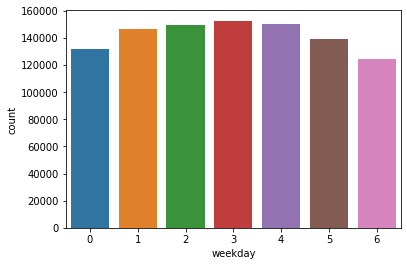

In [44]:
#Taking a 1,000,000 random sample of the dataset and making a bar plot of the 'weekday' variable
#1,000,000 represents a fraction of 0.0023 of 433,521,422
weekday_df = data.select(['weekday']).sample(False, 0.0023, 12345).toPandas()
sns.countplot(x='weekday', data=weekday_df)

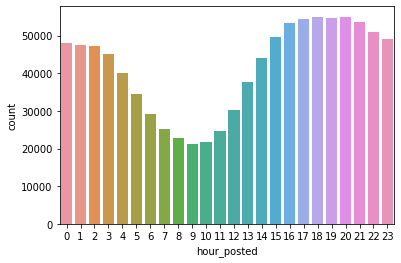

In [45]:
hour_df = data.select(['hour_posted']).sample(False, 0.0023, 12345).toPandas()
sns.countplot(x='hour_posted', data=hour_df)

#### Relationship between variables

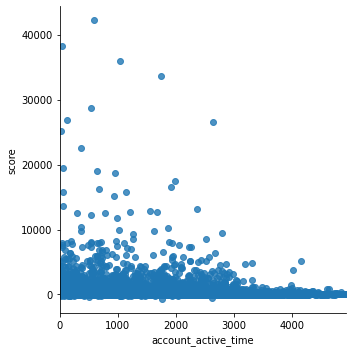

In [46]:
d_df = data.select(['score','account_active_time']).sample(False, 0.0023, 12345).toPandas()
sns.lmplot(y = 'score', x = 'account_active_time', data=d_df)

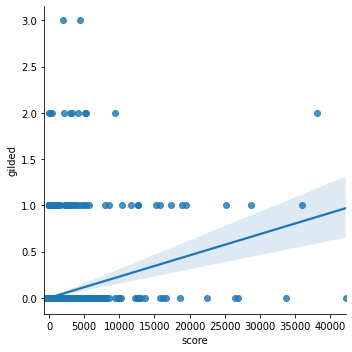

In [47]:
g_df = data.select(['score','gilded']).sample(False, 0.0023, 12345).toPandas()
sns.lmplot(y = 'gilded', x = 'score', data=g_df)

### Machine Learning Models

In [18]:
#Splitting data into training and test 

splitted_data = data.randomSplit([0.8, 0.20], seed=24)
train_data = splitted_data[0]
test_data = splitted_data[1]

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 346829662
Test Dataset Count: 86691760


### Predicting whether a post is 'stickied' or not

In [19]:
#Stickied as our label
stringIndexer_label = StringIndexer(inputCol="stickied", outputCol="label") 

In [20]:
#Converting discrete variables to index columns
stringIndexer_subreddit_type = StringIndexer(inputCol="subreddit_type", outputCol="subreddit_type_IX")
stringIndexer_weekday = StringIndexer(inputCol="weekday", outputCol="weekday_IX")
stringIndexer_can_gild = StringIndexer(inputCol="can_gild", outputCol="can_gild_IX")
stringIndexer_collapsed = StringIndexer(inputCol="collapsed", outputCol="collapsed_IX")
stringIndexer_no_follow = StringIndexer(inputCol="no_follow", outputCol="no_follow_IX")
stringIndexer_send_replies = StringIndexer(inputCol="send_replies", outputCol="send_replies_IX")
stringIndexer_controversiality = StringIndexer(inputCol="controversiality", outputCol="controversiality_IX")
stringIndexer_hour_posted = StringIndexer(inputCol="hour_posted", outputCol="hour_posted_IX")

In [21]:
#Encoding discrete variables

encoder= OneHotEncoderEstimator(
    inputCols=["subreddit_type_IX", "weekday_IX",
               "can_gild_IX","collapsed_IX", "no_follow_IX", "send_replies_IX",
               "controversiality_IX", "hour_posted_IX"],
    outputCols=["subreddit_type_vec", "weekday_vec",
               "can_gild_vec","collapsed_vec", "no_follow_vec", "send_replies_vec",
               "controversiality_vec", "hour_posted_vec"])

In [28]:
#Creating a feature vector with variables of interest
vectorAssembler_features = VectorAssembler(
    inputCols=["gilded", "score", "post_char_len","account_active_time",
               "subreddit_type_vec", "weekday_vec","can_gild_vec",
               "collapsed_vec", "no_follow_vec", "send_replies_vec",
               "controversiality_vec", "hour_posted_vec"],
    outputCol='features')

In [29]:
#Converting label indexes back into the actual labels
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                             labels=stringIndexer_label.fit(data).labels)

In [30]:
evaluator = BinaryClassificationEvaluator(labelCol='label', 
                                             rawPredictionCol='prediction',
                                             metricName='areaUnderROC')

**Logistic Regression**

In [31]:
#Defining estimator
lr = LogisticRegression(labelCol='label', featuresCol='features')

In [32]:
#Building the pipeline
pipeline_LR = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_subreddit_type,
                               stringIndexer_weekday,
                               stringIndexer_can_gild,
                               stringIndexer_collapsed,
                               stringIndexer_no_follow,
                               stringIndexer_send_replies,
                               stringIndexer_controversiality,
                               stringIndexer_hour_posted,
                               encoder,
                               vectorAssembler_features, 
                               lr, 
                               labelConverter])

In [33]:
#Fitting Logistic Regression model
model_LR = pipeline_LR.fit(train_data)

In [34]:
#Evaluating the model
predictions_LR = model_LR.transform(test_data)

In [35]:
auc_LR = evaluator.evaluate(predictions_LR)
auc_LR

0.5039673804143159

**Random Forest**

In [36]:
#Defining estimator
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [37]:
#Building the pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_subreddit_type,
                               stringIndexer_weekday,
                               stringIndexer_can_gild,
                               stringIndexer_collapsed,
                               stringIndexer_no_follow,
                               stringIndexer_send_replies,
                               stringIndexer_controversiality,
                               stringIndexer_hour_posted,
                               encoder,
                               vectorAssembler_features, 
                               rf, 
                               labelConverter])

In [38]:
#Fitting the model
model_rf = pipeline_rf.fit(train_data)

In [39]:
#Evaluating the model
predictions_rf = model_rf.transform(test_data)

In [40]:
auc_rf = evaluator.evaluate(predictions_rf)
auc_rf

0.5

**Gradient Boosted Tree**

In [41]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=15)

In [42]:
#Building the pipeline
pipeline_gbt = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_subreddit_type,
                               stringIndexer_weekday,
                               stringIndexer_can_gild,
                               stringIndexer_collapsed,
                               stringIndexer_no_follow,
                               stringIndexer_send_replies,
                               stringIndexer_controversiality,
                               stringIndexer_hour_posted,
                               encoder,
                               vectorAssembler_features, 
                               gbt, 
                               labelConverter])

In [43]:
#Fitting the model
model_gbt = pipeline_gbt.fit(train_data)

In [44]:
#Evaluating the model
predictions_gbt = model_gbt.transform(test_data)

In [45]:
auc_gbt = evaluator.evaluate(predictions_gbt)
auc_gbt

0.5075491010751847

### Predicting whether a post has 'no_follow' links or not

In [46]:
#no_follow as our label
stringIndexer_label = StringIndexer(inputCol="no_follow", outputCol="label") 

In [47]:
#Converting discrete variables to index columns
stringIndexer_subreddit_type = StringIndexer(inputCol="subreddit_type", outputCol="subreddit_type_IX")
stringIndexer_weekday = StringIndexer(inputCol="weekday", outputCol="weekday_IX")
stringIndexer_can_gild = StringIndexer(inputCol="can_gild", outputCol="can_gild_IX")
stringIndexer_collapsed = StringIndexer(inputCol="collapsed", outputCol="collapsed_IX")
stringIndexer_stickied = StringIndexer(inputCol="stickied", outputCol="stickied_IX")
stringIndexer_send_replies = StringIndexer(inputCol="send_replies", outputCol="send_replies_IX")
stringIndexer_controversiality = StringIndexer(inputCol="controversiality", outputCol="controversiality_IX")
stringIndexer_hour_posted = StringIndexer(inputCol="hour_posted", outputCol="hour_posted_IX")

In [48]:
#Encoding discrete variables

encoder= OneHotEncoderEstimator(
    inputCols=["subreddit_type_IX", "weekday_IX",
               "can_gild_IX","collapsed_IX", "stickied_IX", "send_replies_IX",
               "controversiality_IX", "hour_posted_IX"],
    outputCols=["subreddit_type_vec", "weekday_vec",
               "can_gild_vec","collapsed_vec", "stickied_vec", "send_replies_vec",
               "controversiality_vec", "hour_posted_vec"])

In [49]:
#Creating a feature vector with variables of interest
vectorAssembler_features = VectorAssembler(
    inputCols=["gilded", "score", "post_char_len","account_active_time",
               "subreddit_type_vec", "weekday_vec","can_gild_vec",
               "collapsed_vec", "stickied_vec", "send_replies_vec",
               "controversiality_vec", "hour_posted_vec"],
    outputCol='features')

In [50]:
#Converting label indexes back into the actual labels
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                             labels=stringIndexer_label.fit(data).labels)

In [51]:
evaluator = BinaryClassificationEvaluator(labelCol='label', 
                                             rawPredictionCol='prediction',
                                             metricName='areaUnderROC')

**Logistic Regression**

In [52]:
#Defining estimator
lr = LogisticRegression(labelCol='label', featuresCol='features')

In [53]:
#Building the pipeline
pipeline_LR = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_subreddit_type,
                               stringIndexer_weekday,
                               stringIndexer_can_gild,
                               stringIndexer_collapsed,
                               stringIndexer_stickied,
                               stringIndexer_send_replies,
                               stringIndexer_controversiality,
                               stringIndexer_hour_posted,
                               encoder,
                               vectorAssembler_features, 
                               lr, 
                               labelConverter])

In [54]:
#Fitting Logistic Regression model
model_LR = pipeline_LR.fit(train_data)

In [55]:
#Evaluating the model
predictions_LR = model_LR.transform(test_data)

In [56]:
auc_LR = evaluator.evaluate(predictions_LR)
auc_LR

0.6690379212605336

**Random Forest**

In [57]:
#Defining estimator
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [58]:
#Building the pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_subreddit_type,
                               stringIndexer_weekday,
                               stringIndexer_can_gild,
                               stringIndexer_collapsed,
                               stringIndexer_stickied,
                               stringIndexer_send_replies,
                               stringIndexer_controversiality,
                               stringIndexer_hour_posted,
                               encoder,
                               vectorAssembler_features, 
                               rf, 
                               labelConverter])

In [59]:
#Fitting the model
model_rf = pipeline_rf.fit(train_data)

In [60]:
#Evaluating the model
predictions_rf = model_rf.transform(test_data)

In [61]:
auc_rf = evaluator.evaluate(predictions_rf)
auc_rf

0.9233445119812705

**Gradient Boosted Tree**

In [62]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=15)

In [63]:
#Building the pipeline
pipeline_gbt = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_subreddit_type,
                               stringIndexer_weekday,
                               stringIndexer_can_gild,
                               stringIndexer_collapsed,
                               stringIndexer_stickied,
                               stringIndexer_send_replies,
                               stringIndexer_controversiality,
                               stringIndexer_hour_posted,
                               encoder,
                               vectorAssembler_features, 
                               gbt, 
                               labelConverter])

In [64]:
#Fitting the model
model_gbt = pipeline_gbt.fit(train_data)

In [65]:
#Evaluating the model
predictions_gbt = model_gbt.transform(test_data)

In [66]:
auc_gbt = evaluator.evaluate(predictions_gbt)
auc_gbt

0.9374747179379846